# Experiment plotting

This notebook contains the code for plotting results for several simulations.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.plot import Plotter
import pandas as pd
import pickle
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases

## Model fit

In [ ]:
# Format: {`filename for plot` : `list of `Plot` objects`}
country, area = 'CH', 'TI'
ymax_modelfit = {
    'CH' : {'TI' : 300}
}

plots = {
    f'model-fit-{country}-{area}' : [
        Plot(label='COVID-19 simulated case data', 
            path=(f'continued-lockdown-{country}-{area}/'
                  f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
    ],
}

for plot_filename, plots in plots.items():
    
    # extract plot info
    labels = get_properties(plots, 'label')
    paths = get_properties(plots, 'path')
    
    # load simulations
    results = load_summary_list(paths)
    sims = get_properties(results, 'metadata')
    summaries = get_properties(results, 'summary')
        
    # plots
    plotter = Plotter()
    
    start_date = calibration_start_dates[sims[0].country][sims[0].area]
    start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
    end_date = calibration_lockdown_dates[sims[0].country]['end']

    days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days
    
    mob_settings_paths = calibration_mob_paths[sims[0].country][sims[0].area][1]
    with open(mob_settings_paths, 'rb') as fp:
        mob_settings = pickle.load(fp)

    area_cases = collect_data_from_df(country=country,
         area=area,
         datatype='new',
         start_date_string=start_date,
         end_date_string=end_date)

    sim_cases = downsample_cases(area_cases, mob_settings)      # only downscaling due LK data for cities

    plotter.plot_positives_vs_target(
        summaries, labels,
        sim_cases.sum(axis=1),
        title='Calibration period',
        filename=plot_filename + '-modelfit',
        figsize=(6, 4),
        start_date=start_date,
        errorevery=1, acc=1000,
        ymax=ymax_modelfit[sims[0].country][sims[0].area]
    )
    

## Continued lockdown

In [ ]:
# Format: {`filename for plot` : `list of `Plot` objects`}
country, area = 'CH', 'TI'
ymax = {
    'CH' : {'TI' : 10000}
}

plots = {
    f'continued-lockdown-{country}-{area}' : [
        Plot(label='Baseline',
            path=(f'baseline-{country}-{area}/'
                  f'baseline-{country}-{area}-baseline.pk')),
        Plot(label='Open after 2 weeks', 
            path=(f'continued-lockdown-{country}-{area}/'
                  f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=2.pk')),
        Plot(label='Open after 4 weeks',
            path=(f'continued-lockdown-{country}-{area}/'
                  f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=4.pk')),
        Plot(label='Lockdown', 
            path=(f'continued-lockdown-{country}-{area}/'
                  f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
    ],
}


for plot_filename, plots in plots.items():
    
    # extract plot info
    labels = get_properties(plots, 'label')
    paths = get_properties(plots, 'path')
    
    # load simulations
    results = load_summary_list(paths)
    sims = get_properties(results, 'metadata')
    summaries = get_properties(results, 'summary')
        
    # plots
    plotter = Plotter()
    
    start_date = calibration_start_dates[sims[0].country][sims[0].area]
    start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
    end_date = calibration_lockdown_dates[sims[0].country]['end']

    days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days
    
    plotter.compare_total_infections(
        summaries, 
        titles=labels, 
        filename=plot_filename, 
        start_date=start_date,
        figsize=(6,4), acc=500, 
        legend_is_left=True,
        lockdown_label_y=1000,
        legendXoffset=0.015,
        lockdown_at=days_until_lockdown,
        lockdown_label='Interventions',
        ymax=ymax[sims[0].country][sims[0].area], 
        errorevery=14)
    

## K groups

In [ ]:
# Format: {`filename for plot` : `list of `Plot` objects`}
country, area = 'CH', 'TI'
ymax = {
    'CH' : {'TI' : 10000}
}
plots = {
    f'k-groups-{country}-{area}' : [
        Plot(label='Baseline', 
            path=(f'baseline-{country}-{area}/'
                  f'baseline-{country}-{area}-baseline.pk')),
        Plot(label='K = 2',
            path=(f'k-groups-{country}-{area}/'
                  f'k-groups-{country}-{area}-K_groups=2.pk')),
        Plot(label='K = 3',
            path=(f'k-groups-{country}-{area}/'
                  f'k-groups-{country}-{area}-K_groups=3.pk')),
        Plot(label='K = 4', 
            path=(f'k-groups-{country}-{area}/'
                  f'k-groups-{country}-{area}-K_groups=4.pk')),
    ],

}

for plot_filename, plots in plots.items():
    
    # extract plot info
    labels = get_properties(plots, 'label')
    paths = get_properties(plots, 'path')
    
    # load simulations
    results = load_summary_list(paths)
    sims = get_properties(results, 'metadata')
    summaries = get_properties(results, 'summary')
        
    # plots
    plotter = Plotter()
    
    start_date = calibration_start_dates[sims[0].country][sims[0].area]
    start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
    days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days
    
    plotter.compare_total_infections(
        summaries, 
        titles=labels, 
        filename=plot_filename, 
        start_date=start_date,
        figsize=(6,4), acc=500, 
        legend_is_left=True,
        lockdown_label_y=1000,
        legendXoffset=0.015,
        lockdown_at=days_until_lockdown,
        lockdown_label='Interventions',
        ymax=ymax[sims[0].country][sims[0].area], 
        errorevery=14)

    

## Vulnerable Groups


In [ ]:
# Format: {`filename for plot` : `list of `Plot` objects`}
country, area = 'CH', 'TI'
ymax = {
    'CH' : {'TI' : 10000}
}

ymax_hosp = {
    'CH' : {'TI' : 320}
}
plots = {
    f'vulnerable-groups-{country}-{area}' : [
        Plot(label='Baseline',
            path=(f'baseline-{country}-{area}/'
                  f'baseline-{country}-{area}-baseline.pk')),
        Plot(label='Vulnerable groups', 
            path=(f'vulnerable-groups-{country}-{area}/'
                  f'vulnerable-groups-{country}-{area}.pk')),
    ],

}

for plot_filename, plots in plots.items():
    
    # extract plot info
    labels = get_properties(plots, 'label')
    paths = get_properties(plots, 'path')
    
    # load simulations
    results = load_summary_list(paths)
    sims = get_properties(results, 'metadata')
    summaries = get_properties(results, 'summary')
        
    # plots
    plotter = Plotter()
    
    start_date = calibration_start_dates[sims[0].country][sims[0].area]
    start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
    days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days
    
    plotter.compare_total_infections(
        summaries, 
        titles=labels, 
        filename=plot_filename,
        start_date=start_date,
        figsize=(6,4), acc=500, 
        legend_is_left=True,
        lockdown_label_y=1000,
        legendXoffset=0.02,
        legendYoffset=0.02,
        lockdown_at=days_until_lockdown,
        lockdown_label='Interventions',
        ymax=ymax[sims[0].country][sims[0].area], 
        errorevery=14)
    
    plotter.compare_total_fatalities_and_hospitalizations(
        summaries, 
        titles=labels, 
        filename=plot_filename+ '-hosp', 
        start_date=start_date,
        figsize=(6,4), acc=500, 
        legendXoffset=0.02,
        legendYoffset=0.02,
        legend_is_left=True,
        lockdown_at=days_until_lockdown,
        lockdown_label_y=50,
        lockdown_label='Interventions',
        ymax=ymax_hosp[sims[0].country][sims[0].area], 
        errorevery=14)

### Contact tracing + Isolation

In [ ]:
# Format: {`filename for plot` : `list of `Plot` objects`}

country, area = 'CH', 'TI'
# country, area = 'GER', 'TU'

ymax = {
    'CH' : {'TI' : 120},
    'GER' : {'TU' : 200},
}
plots = {
    f'tracing-{country}-{area}' : [
        Plot(label='Baseline', 
            path=(f'baseline-scenario-b-{country}-{area}/'
                  f'baseline-scenario-b-{country}-{area}-baseline.pk')),
        Plot(label='3h delay, test all, inf capacity, basic',
            path=(f'tracing-{country}-{area}/'
                  f'tracing-{country}-{area}-tracing=isolate+test-delay=3.0-contacts_tested=100000-test_policy=basic.pk')),
        Plot(label='48h delay, test all, inf capacity, basic',
            path=(f'tracing-{country}-{area}/'
                  f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
    ]
}

for plot_filename, plots in plots.items():
        
    # extract plot info
    labels = get_properties(plots, 'label')
    paths = get_properties(plots, 'path')
    
    # load simulations
    results = load_summary_list(paths)
    sims = get_properties(results, 'metadata')
    summaries = get_properties(results, 'summary')
        
    # plots
    plotter = Plotter()
    
    start_date = sims[0].start_date 
    start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
    days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days
    
    plotter.compare_total_infections(
        summaries, 
        titles=labels, 
        filename=plot_filename + '-single', 
        show_single_runs=5,
        start_date=start_date,
        figsize=(6,4), acc=500, 
        legend_is_left=True,
        lockdown_label_y=1000,
        legendXoffset=0.015,
        ymax=ymax[sims[0].country][sims[0].area], 
        errorevery=14)
    
    plotter.compare_total_infections(
        summaries, 
        titles=labels, 
        filename=plot_filename, 
        show_single_runs=False,
        start_date=start_date,
        figsize=(6,4), acc=500, 
        legend_is_left=True,
        lockdown_label_y=1000,
        legendXoffset=0.015,
        ymax=ymax[sims[0].country][sims[0].area], 
        errorevery=14)
    


### Contact tracing + Isolation Compliance

In [ ]:
# Format: {`filename for plot` : `list of `Plot` objects`}
country, area = 'CH', 'TI'
ymax = {
    'CH' : {'TI' : 10000}
}
plots = {
    f'tracing-isolation-compliance-{country}-{area}' : [
        Plot(label='Baseline', 
            path=(f'baseline-scenario-b-{country}-{area}/'
                  f'baseline-scenario-b-{country}-{area}-baseline.pk')),
        Plot(label='10\% Compliance',
            path=(f'tracing-isolation-compliance-{country}-{area}/'
                  f'tracing-isolation-compliance-{country}-{area}-p=0.1.pk')),
        Plot(label='25\% Compliance',
            path=(f'tracing-isolation-compliance-{country}-{area}/'
                  f'tracing-isolation-compliance-{country}-{area}-p=0.25.pk')),
        Plot(label='50\% Compliance',
            path=(f'tracing-isolation-compliance-{country}-{area}/'
                  f'tracing-isolation-compliance-{country}-{area}-p=0.5.pk')),
        Plot(label='75\% Compliance',
            path=(f'tracing-isolation-compliance-{country}-{area}/'
                  f'tracing-isolation-compliance-{country}-{area}-p=0.75.pk')),
        Plot(label='100\% Compliance',
            path=(f'tracing-isolation-{country}-{area}/'
                  f'tracing-isolation-{country}-{area}-delay=48.0.pk')),
    ]
}

for plot_filename, plots in plots.items():
    
    # extract plot info
    labels = get_properties(plots, 'label')
    paths = get_properties(plots, 'path')
    
    # load simulations
    results = load_summary_list(paths)
    sims = get_properties(results, 'metadata')
    summaries = get_properties(results, 'summary')
        
    # plots
    plotter = Plotter()
    
    start_date = calibration_start_dates[sims[0].country][sims[0].area]
    start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
    days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days
    
    plotter.compare_total_infections(
        summaries, 
        titles=labels, 
        filename=plot_filename, 
        start_date=start_date,
        figsize=(6,4), acc=500, 
        legend_is_left=True,
        lockdown_label_y=1000,
        legendXoffset=0.015,
        ymax=ymax[sims[0].country][sims[0].area], 
        errorevery=14)
    


## Conditional Measures

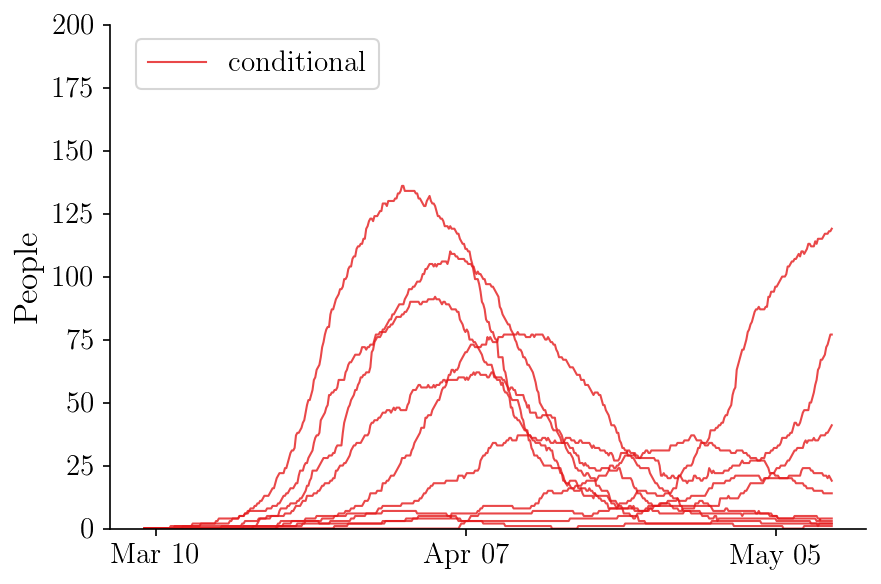

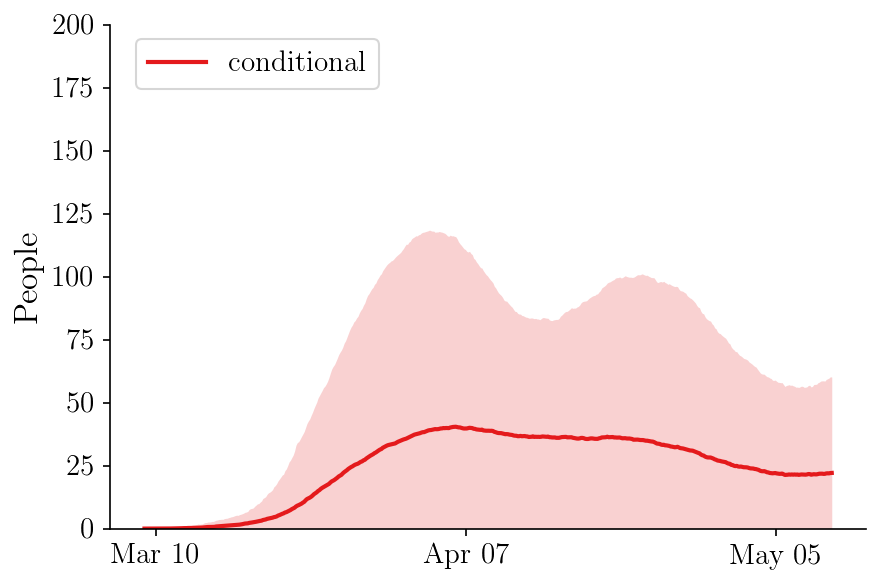

In [27]:
# Format: {`filename for plot` : `list of `Plot` objects`}

country, area = 'CH', 'TI'
# country, area = 'GER', 'TU'

ymax = {
    'CH' : {'TI' : 200},
    'GER' : {'TU' : 500},
}
plots = {
    f'conditional-measures-scenario-b-{country}-{area}' : [
#         Plot(label='Baseline', 
#             path=(f'baseline-scenario-b-{country}-{area}/'
#                   f'baseline-scenario-b-{country}-{area}-baseline.pk')),
        Plot(label='conditional',
            path=(f'conditional-measures-scenario-b-{country}-{area}/'
                  f'conditional-measures-scenario-b-{country}-{area}-max_pos_tests_per_week_per_100k=50-initially_active=False.pk')),
    ]
}

for plot_filename, plots in plots.items():
    
    # extract plot info
    labels = get_properties(plots, 'label')
    paths = get_properties(plots, 'path')
    
    # load simulations
    results = load_summary_list(paths)
    sims = get_properties(results, 'metadata')
    summaries = get_properties(results, 'summary')
            
    # plots
    plotter = Plotter()
    
    start_date = sims[0].start_date 
    
    plotter.compare_total_infections(
        summaries, 
        titles=labels, 
        filename=plot_filename + '-single', 
        show_single_runs=10,
        start_date=start_date,
        figsize=(6,4), acc=500, 
        legend_is_left=True,
        legendXoffset=0.015,
        ymax=ymax[sims[0].country][sims[0].area], 
        errorevery=14)
    
    plotter.compare_total_infections(
        summaries, 
        titles=labels, 
        filename=plot_filename, 
        show_single_runs=False,
        start_date=start_date,
        figsize=(6,4), acc=500, 
        legend_is_left=True,
        legendXoffset=0.015,
        ymax=ymax[sims[0].country][sims[0].area], 
        errorevery=14)
    


## Other experiment

In [ ]:
plots = {
    # tbd
}

## Narrowcasting Plot

In [ ]:
from lib.town_maps import MapIllustrator
from lib.settings.town_settings_tubingen import bbox

In [ ]:
day_start = 7
day_duration = 14

In [ ]:
# make sure to load a summary file that had `store_mob = True`
summary = load_summary(f'summary_file_with_mob.pk')

# plot
ill = MapIllustrator()
ill.marker_radius = 10.0
map_name = f'narrowcasting-plot-{day_start}-{day_duration}'

sitemap = ill.empirical_infection_probability_map(
    bbox=bbox, 
    site_loc=mob.site_loc, 
    site_type=mob.site_type, 
    site_dict=mob.site_dict, 
    map_name=map_name, 
    sim=summary, 
    t0=TO_HOURS * day_start, 
    t1=TO_HOURS * (day_start + day_duration), 
    delta=0.0, 
    r=0)

In [ ]:
sitemap